In [1]:
import os
import yaml
import time
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from linearqmml.parsing import LammpsParser

from linearqmml.regression import ridge_regression
from linearqmml.regression import collected_ridge_regression
from linearqmml.regression import kernel_ridge_regression
from linearqmml.regression import collected_kernel_ridge_regression

from linearqmml.plotting import plot_distance_histogram
from linearqmml.plotting import plot_representations
from linearqmml.plotting import plot_morse_performance

from linearqmml.utils import get_morse_potential
from linearqmml.utils import tqdm_wrap

In [2]:
from linearqmml.smearing import triangle_pdf
from linearqmml.smearing import triangle_cdf

In [3]:
from linearqmml.smearing import get_bin_edges
from linearqmml.smearing import RealspaceHandler
from linearqmml.smearing import distance_matrix_periodic

# Parsing

In [4]:
import linearqmml
package_root = '/'.join(linearqmml.__file__.split('/')[:-2])
example_dir = package_root + '/examples'
assert os.path.isdir(example_dir)

run_stem = 'copper_liquid'
element_symbols = ['Cu']
element_aliases = {'1': 'Cu'}

parsing_handler = LammpsParser(root=example_dir,
                               stem=run_stem, 
                               element_symbols=element_symbols,
                               element_aliases=element_aliases)
print(LammpsParser.__doc__)
print(LammpsParser.__init__.__doc__)


    Parse LAMMPS .xyz and dumps. Supports serialization to yaml.

    Suggest usage:
    1. process_dump()
    2. flatten_entries() to retrieve keys, ase Atoms objects, and energies
    

        Args:
            root (str): Path to working directory.
            stem (str): Prefix for dataset filenames.
            element_symbols (list): List of element symbols (str).
            element_aliases (dict): Optional mapping of aliases
                for element symbols. LAMMPS users typically use integers
                as element identifiers in inputs/outputs. Defaults to
                integer: symbol mapping based on alphabetical sorting plus
                symbol: symbol identity mapping.
        


In [5]:
filename = '{}/{}.dump'.format(parsing_handler.root, parsing_handler.stem)
parsing_handler.process_dump(filename=filename)
print(LammpsParser.process_dump.__doc__)

100%|██████████| 2601/2601 [00:01<00:00, 1735.66it/s]


        Process custom LAMMPS dump file. Obtain by LAMMPS commands:
            "compute peratom all pe/atom"
            "compute pe all reduce sum c_perat"
            "dump fix_dump all custom 1 ${root}/${stem}.dump id x y z c_perat"

        Args:
            filename: Optional filename. Defaults to [root]/[stem].dump
        


In [6]:
local=False
indices = None
key_subset = None
flattened_entries = parsing_handler.flatten_entries(local=local,
                                                    indices=indices,
                                                    key_subset=key_subset)
keys, geometries, energies = flattened_entries
print(LammpsParser.flatten_entries.__doc__)


        Flattens entries into lists e.g. for machine learning.

        Args:
            local (bool): uses list of energies if available instead of sum.
            indices (list): optional subset of integers for slicing the
                flattened list of keys.
            key_subset (list): optional list of keys with which to take subset.

        Returns:
            keys (list): Entry names. Often simply the timesteps from LAMMPS.
            geometries (list): List of ase Atoms objects.
            energies (list): List of energies or lists of local energies.
        


In [7]:
df = pd.DataFrame(columns=['Energy'], index=keys, data=energies)
df['Geometry'] = geometries
df.tail()

,Energy,Geometry
259600,-320.92193,"(Atom('Cu', [5.727547529418534, 7.024117529418..."
259700,-317.78178,"(Atom('Cu', [5.5855575294185345, 7.19925752941..."
259800,-320.83003,"(Atom('Cu', [5.329797529418534, 7.255487529418..."
259900,-322.28102,"(Atom('Cu', [5.320797529418535, 7.350327529418..."
260000,-324.74018,"(Atom('Cu', [5.055277529418534, 7.416527529418..."


# Triangle function demo

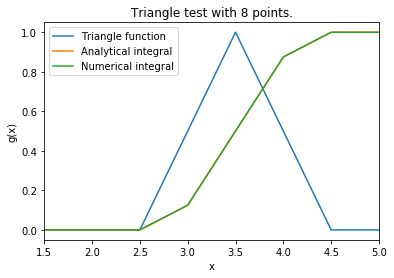

In [8]:
n_test = 8

r_min = 1.5
r_max = 5

x_test = np.linspace(r_min, r_max, n_test).astype(np.float64)
mu_test = 3.5  # center of distribution
sigma_test = 1  # width (radius) of broadening

pdf = triangle_pdf(x_test, mu_test, sigma_test)  # function
cdf = triangle_cdf(x_test, mu_test, sigma_test)  # integral
trapz = [np.trapz(triangle_pdf(x_test[:i+1], mu_test, sigma_test), 
                  x_test[:i+1])
         for i in range(len(x_test))]

plt.title('Triangle test with {} points.'.format(n_test))
plt.plot(x_test, pdf, label='Triangle function')
plt.plot(x_test, cdf, label='Analytical integral')
plt.plot(x_test, trapz, label='Numerical integral')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.xlim(r_min, r_max)
plt.legend()
plt.show()

# Binning Demo


    Generate (n_bins + 1) bin edges spanning r_min to r_max.

    Args:
        n_bins (int): number of bins.
        r_min (float): minimum value (left-most bin edge).
        r_max (float): maximum value (right-most bin edge).
        power (int): power scaling factor for weighting bin widths.

    Returns:
        bin_edges (list): list of n_bins+1 bin edges.
    


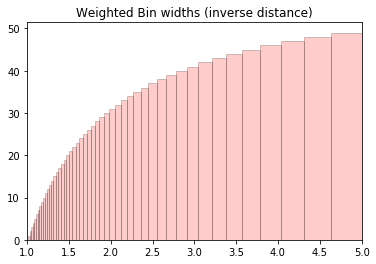

In [25]:
n_bins = 50
r_min = 1
r_max = 5
power = -1

bin_edges = get_bin_edges(n_bins, r_min, r_max, power)
bin_widths = (bin_edges[1:] - bin_edges[:-1]) * 1
plt.bar(bin_edges[:-1], np.arange(n_bins),
        width=bin_widths, color='red', alpha=0.2,
        edgecolor='black', linewidth=1,
        align='edge')
plt.xlim(bin_edges[0], bin_edges[-1])
plt.title('Weighted Bin widths (inverse distance)')
print(get_bin_edges.__doc__)

In [28]:
mu_list = [1.5, 1.8, 2.5, 4.5, 5]

In [10]:
n_bins = 50
r_min = 1.5
r_max = 5.0

sigma_test = 0.1  # width (radius) of broadening
characteristic_bin_width = (r_max - r_min) / n_bins
sigma_factor = sigma_test/characteristic_bin_width

In [27]:
power = 1
handler_r = RealspaceHandler(sigma_factor=sigma_factor,
                             lower_bound=[r_min],
                             upper_bound=[r_max],
                             resolutions=[n_bins],
                             transform_power=power)
print(RealspaceHandler.__init__.__doc__)


        Args:
            sigma_factor (float): smearing parameter to be multiplied by the
                characteristic bin width for each dimension.
            lower_bound (list): list of lower bound (floats) per dimension.
            upper_bound (list): list of upper bound (floats) per dimension.
            resolutions (list): list of number of bins (int) per dimension.
            transform_power (int): scaling power for weighting bin widths.
        


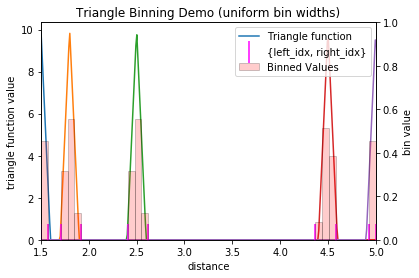

In [12]:
bin_edges = np.array(handler_r.bin_edges[0])
bin_widths = (bin_edges[1:] - bin_edges[:-1]) * 1
x_plot = np.linspace(0, 10, 1000)

fig, ax = plt.subplots(figsize=(6,4))
ax2 = ax.twinx()
ax.set_title('Triangle Binning Demo (uniform bin widths)'.format(n_test))

for mu_test in mu_list:
    ax.plot(x_plot, triangle_pdf(x_plot, mu_test, sigma_test))
    
    bin_values, left_idx, right_idx = handler_r.smear_nd([mu_test])
    ax2.scatter([bin_edges[left_idx], bin_edges[right_idx]],
                [0.02,0.02],
                c='magenta', marker='|', s=500)
    ax2.bar(bin_edges[left_idx:right_idx], bin_values,
            edgecolor='black', linewidth=1,
            width=bin_widths[left_idx:right_idx], color='red', alpha=0.2,
            align='edge')
ax2.scatter([], [],
            c='magenta', marker='|', s=500, 
            label='{left_idx, right_idx}')
ax2.bar([-5], [1], color='red', alpha=0.2,
        edgecolor='black', linewidth=1,
        align='edge', label='Binned Values')
ax2.plot([], [], label='Triangle function')
ax.set_xlabel('distance')
ax.set_ylabel('triangle function value')
ax2.set_ylabel('bin value')
ax.set_xlim(r_min, r_max)
ax2.set_xlim(r_min, r_max)
ax.set_ylim(0, ax.get_ylim()[1])
ax2.set_ylim(0, 1)
ax2.legend()
plt.show()

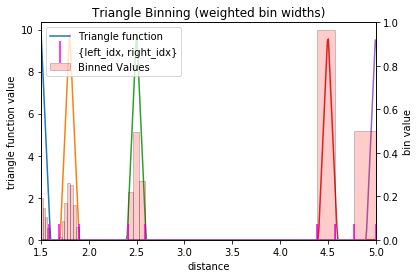

In [13]:
power = -1
handler_inv = RealspaceHandler(sigma_factor=sigma_factor,
                               lower_bound=[r_min],
                               upper_bound=[r_max],
                               resolutions=[n_bins],
                               transform_power=power)

bin_edges = np.array(handler_inv.bin_edges[0])
bin_widths = (bin_edges[1:] - bin_edges[:-1]) * 1
x_plot = np.linspace(0, 10, 1000)

fig, ax = plt.subplots(figsize=(6,4))
ax2 = ax.twinx()
ax.set_title('Triangle Binning (weighted bin widths)'.format(n_test))

for mu_test in mu_list:
    ax.plot(x_plot, triangle_pdf(x_plot, mu_test, sigma_test))
    bin_values, left_idx, right_idx = handler_inv.smear_nd([mu_test])
    ax2.scatter([bin_edges[left_idx], bin_edges[right_idx]],
                [0.02,0.02],
                c='magenta', marker='|', s=500)
    ax2.bar(bin_edges[left_idx:right_idx], bin_values,
            edgecolor='black', linewidth=1,
            width=bin_widths[left_idx:right_idx], color='red', alpha=0.2,
            align='edge')
ax2.scatter([], [],
            c='magenta', marker='|', s=500, 
            label='{left_idx, right_idx}')
ax2.bar([-5], [1], color='red', alpha=0.2,
        edgecolor='black', linewidth=1,
        align='edge', label='Binned Values')
ax2.plot([], [], label='Triangle function')
ax.set_xlabel('distance')
ax.set_ylabel('triangle function value')
ax2.set_ylabel('bin value')
ax.set_xlim(r_min, r_max)
ax2.set_xlim(r_min, r_max)
ax.set_ylim(0, ax.get_ylim()[1])
ax2.set_ylim(0, 1)
ax2.legend()
plt.show()

# Histograms and Distance Matrices Demo

In [14]:
sample_geometry = geometries[0]
dm = distance_matrix_periodic(sample_geometry.get_positions().astype(np.float64),
                              sample_geometry.cell.diagonal().astype(np.float64))
print('Distance Matrix shape:', dm.shape)
sample_distances = dm[np.logical_and(dm>r_min, dm<r_max+0.1)]
print('Number of distances within r_min < r < r_max: ', len(sample_distances))

Distance Matrix shape: (108, 108)
Number of distances within r_min < r < r_max:  5704



    Histogram of pairwise distances, scaled by 1/r^2. The histogram converges
    to the number density at larger distances.
    
    Args:
        distances (list): flattened list of distance observations.
        n_bins (int): Number of bins for histogram. Defaults to 50.
        ax: optional matplotlib axis object on which to plot.

    Returns:
        fig & ax: new matplotlib figure & axis if ax is not specified.
    


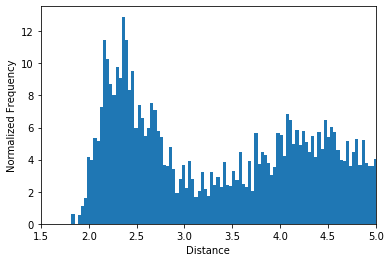

In [15]:
fig, ax = plt.subplots(figsize=(6,4))
plot_distance_histogram([sample_distances], n_bins=100, ax=ax)
ax.set_ylabel('Normalized Frequency')
ax.set_xlabel('Distance')
ax.set_xlim(r_min, r_max)
print(plot_distance_histogram.__doc__)

# 1D Representation vs. Distance Histogram

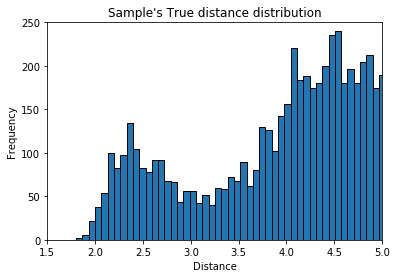

In [16]:
plt.hist(sample_distances, bins=50, edgecolor='black', linewidth=1,)
plt.ylim(0, 250)
plt.xlim(1.5, 5)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title("Sample's True distance distribution")
plt.show()

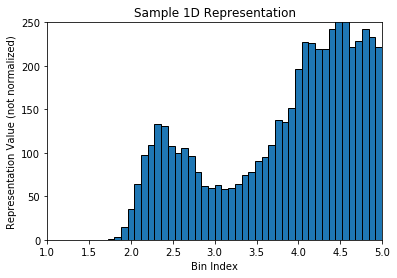


        Generate 1D representation from pairwise (2-body) interactions
            in sample_geometry.

        Args:
            sample_geometry: ase.Atoms object.

        Returns:
            full_grid (np.ndarray): 1D representation vector.
        


In [29]:
sample_representation = handler_r.describe_1d(sample_geometry)
bin_edges = np.array(handler_r.bin_edges[0])
bin_widths = (bin_edges[1:] - bin_edges[:-1]) * 1
plt.bar(bin_edges[:-1],
        sample_representation,
        edgecolor='black', linewidth=1,
        align='edge',
        width=bin_widths)
plt.xlim(r_min, r_max)
plt.ylim(0, 250)
plt.xlabel('Bin Index')
plt.ylabel('Representation Value (not normalized)')
plt.title('Sample 1D Representation')
plt.show()
print(handler_r.describe_1d.__doc__)

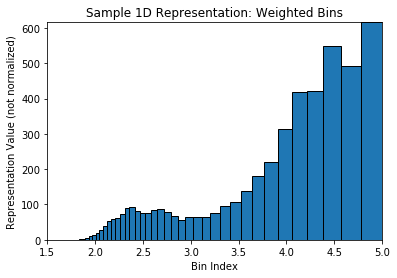

In [18]:
sample_representation = handler_inv.describe_1d(sample_geometry)
bin_edges = np.array(handler_inv.bin_edges[0])
bin_widths = (bin_edges[1:] - bin_edges[:-1]) * 1
plt.bar(bin_edges[:-1],
        sample_representation,
        edgecolor='black', linewidth=1,
        align='edge',
        width=bin_widths)
plt.xlim(r_min, r_max)
plt.ylim(0, np.max(sample_representation))
plt.xlabel('Bin Index')
plt.ylabel('Representation Value (not normalized)')
plt.title('Sample 1D Representation: Weighted Bins')
plt.show()

# Regression Demo


In [19]:
repr_columns = ['x_{}'.format(i) for i in range(n_bins)]
repr_df = pd.DataFrame(columns=repr_columns)

n = 100
entries = sorted(zip(keys, geometries), key=lambda x: int(x[0]))[:n]

for key, geometry in tqdm_wrap(entries):
    representation = handler_r.describe_1d(geometry)
    repr_df.loc[key] = representation

100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


In [20]:
frac_train = 0.8
n_train = int(len(repr_df) * frac_train)

x_train = repr_df.iloc[:n_train].values
y_train = energies[:n_train]

x_test = repr_df.iloc[n_train:].values
y_test = energies[n_train:len(repr_df)]


    Solves the Ax=y with ridge regression
    x = np.linalg.inv(A.T*A + alpha * I)*A.T*y

    Args:
        A (np.ndarray): representations.
        y (np.ndarray): energies.
        lambda_ (float): regularization parameter.

    Returns:
        beta (np.ndarray): coefficients.
        y_beta (np.ndarray): predicted energies.
        A_mean (np.ndarray): average representation; used for centering.
    
5.025536886803584 % error


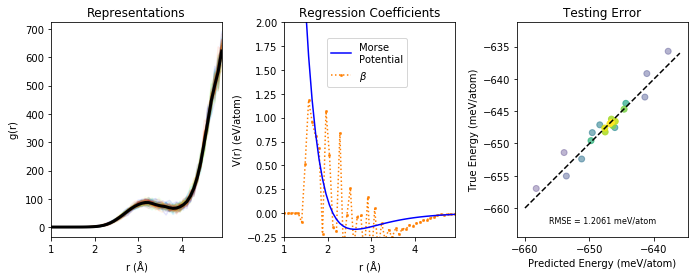

In [30]:
coefficients, predictions, input_mean = ridge_regression(x_train, 
                                                         y_train, 
                                                         lambda_=1e-1)
print(ridge_regression.__doc__)
test_predictions = np.dot(coefficients, x_test.T)

r_range = handler_r.bin_edges[0][:-1]
plot_morse_performance(coefficients, 
                       test_predictions, 
                       y_test, 
                       repr_df.values, 
                       r_range)
plt.show()

# Weighted Regression Demo


In [22]:
repr_columns = ['x_{}'.format(i) for i in range(n_bins)]
repr_df = pd.DataFrame(columns=repr_columns)

n = 100
entries = sorted(zip(keys, geometries), key=lambda x: int(x[0]))[:n]

for key, geometry in tqdm_wrap(entries):
    representation = handler_inv.describe_1d(geometry)
    repr_df.loc[key] = representation

100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


In [23]:
frac_train = 0.8
n_train = int(len(repr_df) * frac_train)

x_train = repr_df.iloc[:n_train].values
y_train = energies[:n_train]

x_test = repr_df.iloc[n_train:].values
y_test = energies[n_train:len(repr_df)]

5.025536886803584 % error


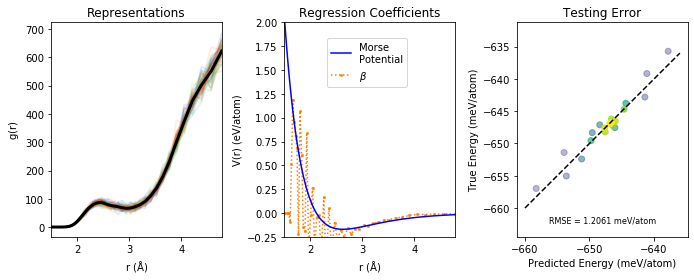

In [24]:
coefficients, predictions, input_mean = ridge_regression(x_train, 
                                                         y_train, 
                                                         lambda_=1e-1)

test_predictions = np.dot(coefficients, x_test.T)

r_range = handler_inv.bin_edges[0][:-1]
plot_morse_performance(coefficients, 
                       test_predictions, 
                       y_test, 
                       repr_df.values, 
                       r_range)
plt.show()